In [11]:
from datar.datasets import world_bank_pop
from datar.all import *
from pipda import register_verb, register_func
from plotnine import ggplot, geom_col, aes, theme_classic, ylab
import pandas
import timeit

REPEATS = 20
options(dplyr_summarise_inform=False)
register_verb.warn_astnode_failure = False
register_func.warn_astnode_failure = False
ggplot = register_verb(func=ggplot)

## Prepare data

In [12]:
# add weight to make groups distribute differently in different scales
wholedata = (
    world_bank_pop
    >> mutate(count=100)
    >> uncount(f.count)
    >> mutate(weight=row_number())
)

datasets = {
    "1%": wholedata >> slice_sample(prop=0.01, weight_by=f.weight),
    "5%": wholedata >> slice_sample(prop=0.05, weight_by=f.weight),
    "10%": wholedata >> slice_sample(prop=0.1, weight_by=f.weight),
    "20%": wholedata >> slice_sample(prop=0.2, weight_by=f.weight),
    "30%": wholedata >> slice_sample(prop=0.3, weight_by=f.weight),
    "40%": wholedata >> slice_sample(prop=0.4, weight_by=f.weight),
    "50%": wholedata >> slice_sample(prop=0.5, weight_by=f.weight),
    "60%": wholedata >> slice_sample(prop=0.6, weight_by=f.weight),
    "70%": wholedata >> slice_sample(prop=0.7, weight_by=f.weight),
    "80%": wholedata >> slice_sample(prop=0.8, weight_by=f.weight),
    "90%": wholedata >> slice_sample(prop=0.9, weight_by=f.weight),
    "100%": wholedata,
}
for perc, data in datasets.items():
    print(f"{perc}: (nrow={nrow(data)})")


1%: (nrow=1056)
5%: (nrow=5280)
10%: (nrow=10560)
20%: (nrow=21120)
30%: (nrow=31680)
40%: (nrow=42240)
50%: (nrow=52800)
60%: (nrow=63360)
70%: (nrow=73920)
80%: (nrow=84480)
90%: (nrow=95040)
100%: (nrow=105600)


In [13]:
def run(func, grouping=False):
    """A decorator to run all datasets"""
    times = {}
    for perc, data in datasets.items():
        if grouping == "datar":
            data = data >> group_by(f.country, f.indicator)
        elif grouping == "pandas":
            data = data.groupby(["country", "indicator"])
        times[perc] = timeit.timeit(lambda: func(data), number=REPEATS)
    out = tibble(times) >> t()
    return out.iloc[:, 0]


def plot(timedf):
    scale = factor(rep(timedf.Scale, ncol(timedf) - 1), levels=datasets)
    timedf = (
        timedf
        >> pivot_longer(~f.Scale, names_to="Group", values_to="Time")
        >> mutate(Scale=scale, Time=f.Time)
    )
    # timedf['Time'] = numpy.log2(timedf.Time + 1)

    return (
        (timedf >> ggplot())
        + geom_col(
            aes(x="Scale", y="Time", fill="Group"),
            stat="identity",
            position="dodge",
        )
        +
        # ylab('log2(Time + 1)') +
        theme_classic()
    )


## `datar.dplyr.group_by()` v.s. `DataFrame.groupby()`

Overhead includes:
- Expression object parsing
- Group data computation (to align with dplyr's API)
- Assigning grouping variables to data frame (`dplyr`'s `group_by()` accepts external data)  
    Optimize it if the data passed in is a column of original data frame?

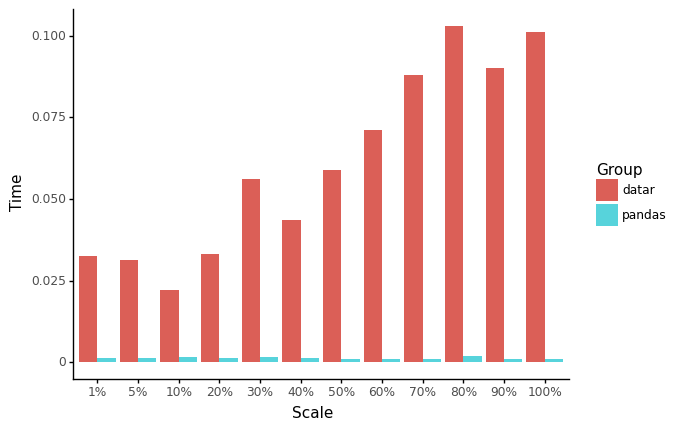

<ggplot: (8778106536757)>

In [20]:
groupby_pandas = run(lambda data: data.groupby(["country", "indicator"]))
groupby_datar = run(lambda data: data >> group_by(f.country, f.indicator))

groupby_time = (
    tibble(
        pandas=groupby_pandas,
        datar=groupby_datar,
    )
    >> rownames_to_column("Scale")
)
plot(groupby_time)


## Aggregating results on single columns

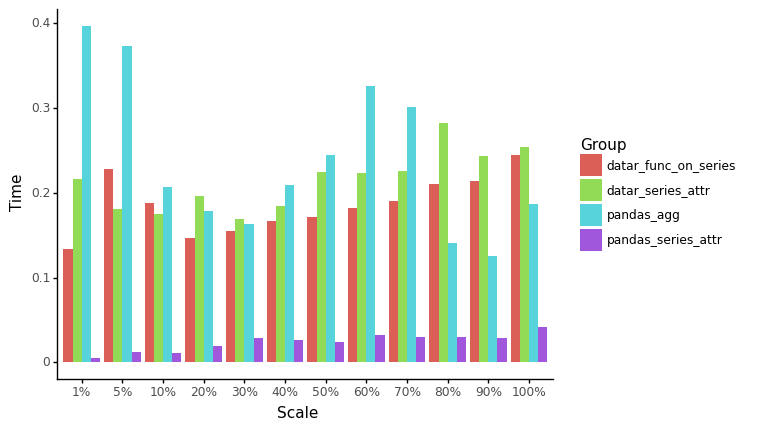

<ggplot: (8778105688189)>

In [15]:
# See: https://github.com/pwwang/datar/issues/33

agg_pandas1 = run(
    lambda data: data.agg(avg_2000=("2000", "mean")), grouping="pandas"
)
agg_pandas2 = run(lambda data: data["2000"].mean(), grouping="pandas")
agg_datar1 = run(
    lambda data: data >> summarise(avg_2000=f["2000"].mean()), grouping="datar"
)
agg_datar2 = run(
    lambda data: data >> summarise(avg_2000=mean(f["2000"])), grouping="datar"
)

agg_time = (
    tibble(
        pandas_agg=agg_pandas1,
        pandas_series_attr=agg_pandas2,
        datar_series_attr=agg_datar1,
        datar_func_on_series=agg_datar2,
    )
    >> rownames_to_column("Scale")
)
plot(agg_time)


## Applying functions

In most cases, depends on the number of groups. We have to attach group data and the index of the group for the group context function to work, such as `cur_group_id()`, `cur_group_rows()`, etc.

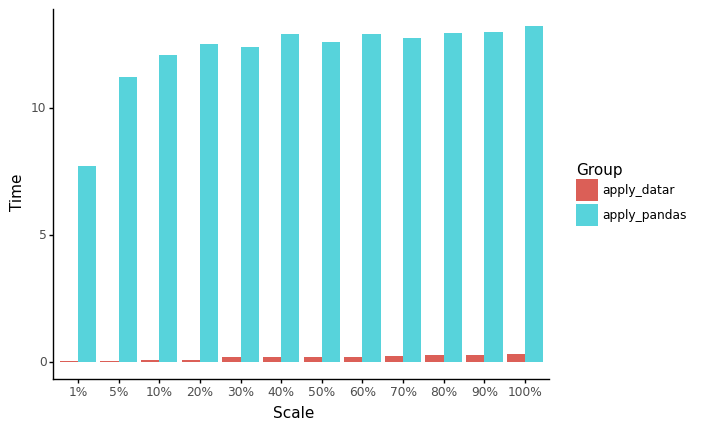

<ggplot: (8778105709753)>

In [16]:
apply_pandas = run(
    lambda data: data.apply(
        lambda df: pandas.Series({
            'prod00s': df['2000'] * df['2001'] * df['2002'],
        })
    ), 
    grouping='pandas'
)
apply_datar = run(
    lambda data: data >> summarise(
        prod00s = f['2000'] * f['2001'] * f['2002']
    )
)

apply_time = tibble(
    apply_pandas=apply_pandas, 
    apply_datar=apply_datar, 
) >> rownames_to_column('Scale')

plot(apply_time)

## `datar.dplyr.filter()` vs `DataFrame.loc[]` vs `DataFrame.query()`

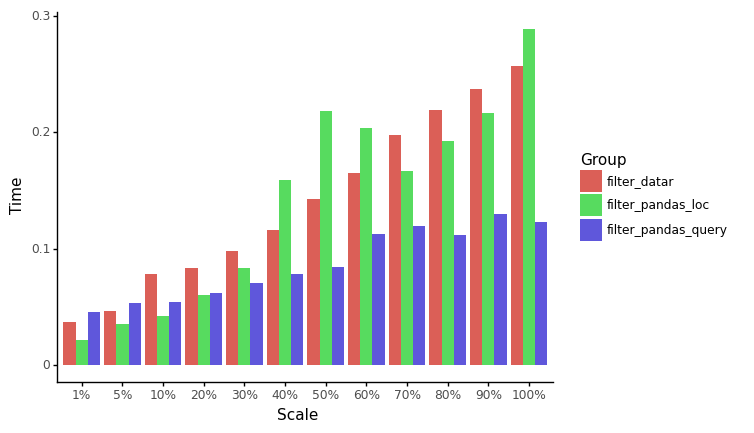

<ggplot: (8778105745573)>

In [17]:
# See: https://github.com/pwwang/datar/issues/37

filter_pandas1 = run(
    lambda data: data.loc[
        (data.country == "ABW") & (data.country == "SP.URB.TOTL")
    ]
)
filter_pandas2 = run(
    lambda data: data.query("country == 'ABW' & country == 'SP.URB.TOTL'")
)
filter_datar = run(
    lambda data: data >> filter(
        (f.country == "ABW") & (f.country == "SP.URB.TOTL")
    )
)

filter_time = (
    tibble(
        filter_pandas_loc=filter_pandas1,
        filter_pandas_query=filter_pandas2,
        filter_datar=filter_datar,
    )
    >> rownames_to_column("Scale")
)

plot(filter_time)
